In [1]:
%matplotlib inline

In [2]:
## Subs up to and including sub009 had a'9' meg code before each experiment part, rather than at the beginning of each trial
## Subs up to and including sub009 lacked a '7' MEG code when the response screen came on. 
## Subs up to and including sub009 had 80/81 for both precue/postcue; afterwards precue was 80/81, postcue was 180/181

##Sub sub010 had messed up triggers with no post cue, no response, and lacking first or last RSVP image 
##Sub sub011 went back to having '9' codes sent too often, but it worked. Also marked pre- vs. post cue with 180/181



# Classify pre-cue vs no-cue
# Target identity
# Target identity when precued vs nocued


import sys
import numpy as np
import pandas as pd
import seaborn as sns
import os

import mne
from mne.decoding import LinearModel
import matplotlib.pyplot as plt

print(__doc__)

# Preprocess data
# Load and filter data, set up epochs
raw_fnames = ['/project/3018000.20/raw/sub-002/ses-meg01/sub002ses01_3018000.20_20170401_01.ds',
             '/project/3018000.20/raw/sub-003/ses-meg01/sub003ses01_3018000.20_20170404_01.ds',
             '/project/3018000.20/raw/sub-004/ses-meg01/sub004ses01_3018000.20_20170404_01.ds',
             '/project/3018000.20/raw/sub-005/ses-meg01/sub005ses01_3018000.20_20170404_01.ds',
             '/project/3018000.20/raw/sub-006/ses-meg01/sub006ses01_3018000.20_20170404_01.ds',
             '/project/3018000.20/raw/sub-007/ses-meg01/sub007ses01_3018000.20_20170416_01.ds',
             '/project/3018000.20/raw/sub-009/ses-meg01/sub009ses01_3018000.20_20170418_01.ds',
             '/project/3018000.20/raw/sub-010/ses-meg01/sub010ses01_3018000.20_20170418_01.ds',
             '/project/3018000.20/raw/sub-011/ses-meg01/sub011ses01_3018000.20_20170419_01.ds',
             '/project/3018000.20/raw/sub-012/ses-meg01/sub012ses01_3018000.20_20170420_01.ds',
             '/project/3018000.20/raw/sub-013/ses-meg01/sub013ses01_3018000.20_20170425_01.ds',
             '/project/3018000.20/raw/sub-014/ses-meg01/sub014ses01_3018000.20_20170426_01.ds',
              '/project/3018000.20/raw/sub-015/ses-meg01/sub015ses01_3018000.20_20170427_01.ds',
              '/project/3018000.20/raw/sub-016/ses-meg01/sub016ses01_3018000.20_20170427_01.ds']

raw_fname = '/project/3018000.20/raw/sub-011/ses-meg01/sub011ses01_3018000.20_20170419_01.ds'

analysis_list = ['precue_vs_nocue','postcue_vs_nocue','target_identity',
                 'precue_target_id','noprecue_target_id','precue_id',
                 'target_category','precue_target_cat','noprecue_target_cat',
                 'precue_picture1','precue_picture2','precue_picture3',
                 'noprecue_picture1','noprecue_picture2','noprecue_picture3',
                 'precue_picture4','precue_picture5','precue_picture6',
                 'noprecue_picture4','noprecue_picture5','noprecue_picture6']   

analysis_list = ['precue_vs_nocue']  

only_response_correct = False
only_response_incorrect = False




subject = raw_fname[42:48]
print subject

raw = mne.io.read_raw_ctf(raw_fname , preload=False)


#----
if subject in ['sub002','sub015']: #these subjects have shortest_event warnings
    events = mne.find_events(raw,stim_channel='UPPT001', shortest_event=1)#min_duration=1/raw.info['sfreq'])
else:
    events = mne.find_events(raw,stim_channel='UPPT001')

print 'Found %s events, first twenty:' % len(events)
print events[:20]

Automatically created module for IPython interactive environment
sub011
ds directory : /project/3018000.20/raw/sub-011/ses-meg01/sub011ses01_3018000.20_20170419_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.93   75.89    0.00 mm <->    0.93   75.89   -0.00 mm (orig :  -61.28   42.57 -274.76 mm) diff =    0.000 mm
      -0.93  -75.89    0.00 mm <->   -0.93  -75.89    0.00 mm (orig :   39.57  -70.30 -286.11 mm) diff =    0.000 mm
     106.10    0.00    0.00 mm <->  106.10    0.00   -0.00 mm (orig :   67.56   57.14 -272.32 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 8 EEG channels from channel info
    8 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /project/3018000.20/raw/sub-011/ses-meg01/sub011ses01_3018

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
#----

df = pd.DataFrame(events)
df.columns =  ['time','prev','curr']


if subject in ['sub002','sub003','sub004','sub005','sub006','sub007','sub009','sub011','sub012','sub013','sub014',
              'sub015','sub016','sub017','sub018','sub020']:
    df1  = df[df.curr !=9]
    df1  = df1[df1.curr !=77] #for sub015 and sub016


elif subject in ['sub010']:
    df1 = df

#---- 
event_list = []
response_correct_list = []
cuetype_list = []
precuetype_list = []
postcuetype_list = []
target_identity_list = []
target_category_list = []



print subject
infile = open('events/s'+subject[-3:]+'_events.txt','r')
for i,line in enumerate(infile):
    if i < 10:
        print line.split(',')
    response_correct_list.append(int(line.split(',')[0]))
    cuetype_list.append(line.split(',')[1])
    precuetype_list.append(line.split(',')[2])
    postcuetype_list.append(line.split(',')[3])
    target_identity_list.append(line.split(',')[4])
    target_category_list.append(line.split(',')[5])
    event_list.append(int(line.split(',')[-1]))

#----

print 'total events:',len(event_list)
print 'triggered events:',len(df1)

#----

if subject == 'sub010':
    repeat_arr = [item for item in event_list if item not in [180,181]] #postcue not triggered
    repeat_arr = [item for i,item in enumerate(repeat_arr) if repeat_arr[i-1] not in [80,81]] #first image not shown
else:
    repeat_arr = event_list

def put(df, column, values):
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(values)
    values = le.transform(values) 
    df[column] = 0
    np.put(df[column], np.arange(len(df)), values)
    df[column] = le.inverse_transform(df[column])

#Fill in the events list, even if it's longer than the trigger events
put(df1, 'event_list', repeat_arr)

#----

df1['difference'] = df1.curr - df1.event_list

#----

try:
    wrong_event_timepoint = np.array(df1[(np.abs(df1.difference) > 9) & (np.abs(df1.difference) != 100)]['time'])[0]
    print wrong_event_timepoint
    print df1[(df1['time'] > wrong_event_timepoint-900)].head(20)
except IndexError:
    print "everything looks good now"
    wrong_event_timepoint = False

#----

while wrong_event_timepoint:
    #Look at time course just before and after wrong timepoint
    #print df1[(df1['time'] > wrong_event_timepoint-900)].head(20)
    df1 = df1[df1['time'] != wrong_event_timepoint].reset_index(drop=True)

    #Do it all over again
    put(df1, 'event_list', repeat_arr)
    df1['difference'] = df1.curr - df1.event_list

    try:
        wrong_event_timepoint = np.array(df1[(np.abs(df1.difference) > 9) & (np.abs(df1.difference) != 100)]['time'])[0]
        print wrong_event_timepoint
    except IndexError:
        print "everything looks good now"
        wrong_event_timepoint = False


#----

#is there still a descrepancy?
print 'total events:',len(event_list)
print 'triggered events:',len(df1)


#----

if subject == 'sub002':
    ## Subject two did not finish recording the last few trials, hence the discrepancy
    print event_list[-18:]
    print df1.event_list.tail(10).values
elif subject == 'sub003':
    ## Subject three did not finish recording the last few trials, hence the discrepancy
    print event_list[-18:]
    print df1.event_list.tail(10).values
elif subject == 'sub004':
    ## Subject four did not finish recording the last few trials, hence the discrepancy
    print event_list[-18:]
    print df1.event_list.tail(10).values
elif subject == 'sub005':
    ## Subject five did not finish recording the last few trials, hence the discrepancy
    print event_list[-18:]
    print df1.event_list.tail(10).values
elif subject == 'sub006':
    print "all good"
    print event_list[-10:]
    print df1.event_list.tail(10).values
elif subject == 'sub007':
    print "all good"
    print event_list[-10:]
    print df1.event_list.tail(10).values
elif subject == 'sub009':
    print "all good"
    print event_list[-10:]
    print df1.event_list.tail(10).values
elif subject == 'sub010':
    ## Subject ten finished but had trigger issues
    print 'total events:',len(repeat_arr)
    print 'triggered events:',len(df1)
elif subject == 'sub011':
    print "all good"
    print 'total events:',len(repeat_arr)
    print 'triggered events:',len(df1)
elif subject == 'sub012':
    print "all good"
    print 'total events:',len(repeat_arr)
    print 'triggered events:',len(df1)
elif subject == 'sub013':
    print "all good"
    print 'total events:',len(repeat_arr)
    print 'triggered events:',len(df1)
elif subject == 'sub014':
    print "all good"
    print 'total events:',len(repeat_arr)
    print 'triggered events:',len(df1)
elif subject == 'sub015':
    print "all good"
    print 'total events:',len(repeat_arr)
    print 'triggered events:',len(df1)
elif subject == 'sub016':
    print "all good"
    print 'total events:',len(repeat_arr)
    print 'triggered events:',len(df1)

#---- SET UP EVENTS ---- #

if subject == 'sub010':
    for list_item in [response_correct_list,cuetype_list,precuetype_list,postcuetype_list,target_identity_list,target_category_list]:
        del list_item[7::8] #remove every 8th item (to account for no post-cue)
        del list_item[6::7] #remove every 7th item (to account for no first image)
put(df1, 'response_correct', response_correct_list)
put(df1, 'cue_type', cuetype_list)
put(df1, 'precue_type', precuetype_list)
put(df1, 'postcue_type', postcuetype_list)
put(df1, 'target_identity', target_identity_list)
put(df1, 'target_category', target_category_list)


#----

df1['event_list'] = df1['event_list'].astype(str)

df1['target'] = 0
df1.loc[df1.event_list.str.endswith('9'),'target'] = 1


if subject == 'sub010':
    put(df1, 'exp_part', [1,3,4,5,6,7])
else:
    put(df1, 'exp_part', [1,2,3,4,5,6,7,8])


df1['event_list'] = df1['event_list'].astype(int)

sub011
['1', 'precue', 'precue', 'nocue', 'car', 'object', '81\n']
['1', 'precue', 'precue', 'nocue', 'car', 'object', '23\n']
['1', 'precue', 'precue', 'nocue', 'car', 'object', '21\n']
['1', 'precue', 'precue', 'nocue', 'car', 'object', '13\n']
['1', 'precue', 'precue', 'nocue', 'car', 'object', '11\n']
['1', 'precue', 'precue', 'nocue', 'car', 'object', '22\n']
['1', 'precue', 'precue', 'nocue', 'car', 'object', '14\n']
['1', 'precue', 'precue', 'nocue', 'car', 'object', '180\n']
['1', 'postcue', 'nocue', 'postcue', 'car', 'object', '80\n']
['1', 'postcue', 'nocue', 'postcue', 'car', 'object', '23\n']
total events: 3936
triggered events: 3936
everything looks good now
total events: 3936
triggered events: 3936
all good
total events: 3936
triggered events: 3936


In [4]:
df1[(df1.response_correct == 1) & (df1.event_list == 81)]
df1[(df1.response_correct == 1) & (df1.cue_type.isin(['precue','nocue'])) & (df1.event_list == 80)]

,time,prev,curr,event_list,difference,response_correct,cue_type,precue_type,postcue_type,target_identity,target_category,target,exp_part
176,104730,0,80,80,0,1,nocue,nocue,nocue,False,False,0,1
368,199291,0,80,80,0,1,nocue,nocue,nocue,False,False,0,1
464,246592,0,80,80,0,1,nocue,nocue,nocue,False,False,0,1
688,356933,0,80,80,0,1,nocue,nocue,nocue,False,False,0,1
736,380533,0,80,80,0,1,nocue,nocue,nocue,False,False,0,1
832,427774,0,80,80,0,1,nocue,nocue,nocue,False,False,0,1
1088,623416,0,80,80,0,1,nocue,nocue,nocue,False,False,0,1
1408,781038,0,80,80,0,1,nocue,nocue,nocue,False,False,0,1
1648,899320,0,80,80,0,1,nocue,nocue,nocue,False,False,0,1
1680,915060,0,80,80,0,1,nocue,nocue,nocue,False,False,0,1


In [236]:
analysis_list = ['noprecue_picture5']
analysis_list = ['precue_picture1']
analysis_list = ['precue_picture2']

analysis_list = ['precue_picture1', 'precue_picture2','precue_picture3',
                 'precue_picture4','precue_picture5','precue_picture6',
                 'noprecue_picture1','noprecue_picture2','noprecue_picture3',
                 'noprecue_picture4','noprecue_picture5','noprecue_picture6']   

analysis_list = ['postcue_vs_nocue']



In [237]:
for analysis in analysis_list:

    print "RUNNING",analysis,"..."


    #----

    if only_response_correct:
        df1 = df1[df1.response_correct == 1]
    elif only_response_incorrect:
        df1 = df1[df1.response_correct == 0]


    if analysis == 'precue_vs_nocue':
        precue = df1[(df1.cue_type.isin(['precue','nocue'])) & ((df1.event_list == 80) | (df1.event_list == 81))]
        events = np.array(precue[['time','prev','event_list']])
        tmin, tmax = -.1, 2.5 #from beginning of blank, to end of trailing blank
        baseline = (None, 0.0) #from beginning of blank to trigger of first picture

    elif analysis == 'postcue_vs_nocue':            
        postcue = df1[(df1.cue_type.isin(['postcue','nocue'])) & ((df1.event_list == 180) | (df1.event_list == 181))]
        events = np.array(postcue[['time','prev','event_list']])   
        tmin, tmax = -.1, 2.5 #from beginning of blank, to end of trailing blank
        baseline = (None, 0.0) #from beginning of blank to trigger of first picture
    elif analysis == 'target_identity':
        target = df1[df1.target == 1]
        events = np.array(target[['time','prev','event_list']])
        tmin, tmax = -.1, 2.5 #from beginning of blank, to end of trailing blank
        baseline = (None, 0.0) #from beginning of blank to trigger of first picture
    elif analysis == 'precue_target_id':
        precue_target =  df1[(df1.target == 1) & (df1.cue_type == 'precue')]
        events = np.array(precue_target[['time','prev','event_list']])
        tmin, tmax = -.1, 2.5 #from beginning of blank, to end of trailing blank
        baseline = (None, 0.0) #from beginning of blank to trigger of first picture
    elif analysis == 'noprecue_target_id':
        noprecue_target =  df1[(df1.target == 1) & (df1.cue_type.isin(['postcue', 'nocue']))]
        events = np.array(noprecue_target[['time','prev','event_list']])
        tmin, tmax = -.1, 2.5 #from beginning of blank, to end of trailing blank
        baseline = (None, 0.0) #from beginning of blank to trigger of first picture
    elif analysis == 'noprecue_target_id_onlypostcue':
        noprecue_target =  df1[(df1.target == 1) & (df1.cue_type.isin(['postcue']))]
        events = np.array(noprecue_target[['time','prev','event_list']])
        tmin, tmax = -.1, 2.5 #from beginning of blank, to end of trailing blank
        baseline = (None, 0.0) #from beginning of blank to trigger of first picture


    elif analysis == 'precue_id':
        precue_id = df1[(df1.cue_type == 'precue') & (df1.event_list == 81)]
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        le.fit(precue_id.target_identity)
        precue_id['num_labels'] = le.transform(precue_id.target_identity) 
        events = np.array(precue_id[['time','prev','num_labels']])
        tmin, tmax = -.1, 2.5 #from beginning of blank, to end of trailing blank
        baseline = (None, 0.0) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_target_cat':            
        precue_target = df1[(df1.target == 1) & (df1.cue_type == 'precue')]
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        le.fit(precue_target.target_category)
        precue_target['num_labels'] = le.transform(precue_target.target_category) 
        events = np.array(precue_target[['time','prev','num_labels']])
        tmin, tmax = -.1, 2.5 #from beginning of blank, to end of trailing blank
        baseline = (None, 0.0) #from beginning of blank to trigger of first picture
    elif analysis == 'noprecue_target_cat':
        noprecue_target =  df1[(df1.target == 1) & (df1.cue_type.isin(['postcue', 'nocue']))]
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        le.fit(noprecue_target.target_category)
        noprecue_target['num_labels'] = le.transform(noprecue_target.target_category) 
        events = np.array(noprecue_target[['time','prev','num_labels']])
        tmin, tmax = -.1, 2.5 #from beginning of blank, to end of trailing blank
        baseline = (None, 0.0) #from beginning of blank to trigger of first picture
    elif analysis == 'target_category':
        target =  df1[(df1.target == 1)]
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        le.fit(target.target_category)
        target['num_labels'] = le.transform(target.target_category) 
        events = np.array(target[['time','prev','num_labels']])
        tmin, tmax = -.1, 2.5 #from beginning of blank, to end of trailing blank
        baseline = (None, 0.0) #from beginning of blank to trigger of first picture


    elif analysis == 'precue_picture1':
        pic1 =  df1[(df1.exp_part == 2) & (df1.target != 1) & (df1.cue_type == 'precue')]
        events = np.array(pic1[['time','prev','event_list']])
        tmin, tmax = -.3, .9 #from beginning of blank, to end of trailing blank
        baseline = (-.3, 0.0) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_picture2':
        pic2 =  df1[(df1.exp_part == 3) & (df1.target != 1) & (df1.cue_type == 'precue')]
        events = np.array(pic2[['time','prev','event_list']])
        tmin, tmax = -.4, .8 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.1) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_picture3':
        pic3 =  df1[(df1.exp_part == 4) & (df1.target != 1) & (df1.cue_type == 'precue')]
        events = np.array(pic3[['time','prev','event_list']])
        tmin, tmax = -.5, .7 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.2) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_picture4':
        pic4 =  df1[(df1.exp_part == 5) & (df1.target != 1) & (df1.cue_type == 'precue')]
        events = np.array(pic4[['time','prev','event_list']])
        tmin, tmax = -.6, .6 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.3) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_picture5':
        pic5 =  df1[(df1.exp_part == 6) & (df1.target != 1) & (df1.cue_type == 'precue')]
        events = np.array(pic5[['time','prev','event_list']])
        tmin, tmax = -.7, .5 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.4) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_picture6':
        pic6 =  df1[(df1.exp_part == 7) & (df1.target != 1) & (df1.cue_type == 'precue')]
        events = np.array(pic6[['time','prev','event_list']])
        tmin, tmax = -.8, .4 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.5) #from beginning of blank to trigger of first picture


    elif analysis == 'noprecue_picture1':
        pic1 =  df1[(df1.exp_part == 2) & (df1.target != 1) & (df1.cue_type.isin(['postcue', 'nocue']))]
        events = np.array(pic1[['time','prev','event_list']])
        tmin, tmax = -.3, .9 #from beginning of blank, to end of trailing blank
        baseline = (-.3, 0.0) #from beginning of blank to trigger of first picture
    elif analysis == 'noprecue_picture2':
        pic2 =  df1[(df1.exp_part == 3) & (df1.target != 1) & (df1.cue_type.isin(['postcue', 'nocue']))]
        events = np.array(pic2[['time','prev','event_list']])
        tmin, tmax = -.4, .8 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.1) #from beginning of blank to trigger of first picture
    elif analysis == 'noprecue_picture3':
        pic3 =  df1[(df1.exp_part == 4) & (df1.target != 1) & (df1.cue_type.isin(['postcue', 'nocue']))]
        events = np.array(pic3[['time','prev','event_list']])
        tmin, tmax = -.5, .7 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.2) #from beginning of blank to trigger of first picture

    elif analysis == 'noprecue_picture4':
        pic4 =  df1[(df1.exp_part == 5) & (df1.target != 1) & (df1.cue_type.isin(['postcue', 'nocue']))]
        events = np.array(pic4[['time','prev','event_list']])
        tmin, tmax = -.6, .6 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.3) #from beginning of blank to trigger of first picture

    elif analysis == 'noprecue_picture5':
        pic5 =  df1[(df1.exp_part == 6) & (df1.target != 1) & (df1.cue_type.isin(['postcue', 'nocue']))]
        events = np.array(pic5[['time','prev','event_list']])
        tmin, tmax = -.7, .5 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.4) #from beginning of blank to trigger of first picture

    elif analysis == 'noprecue_picture6':
        pic6 =  df1[(df1.exp_part == 7) & (df1.target != 1) & (df1.cue_type.isin(['postcue', 'nocue']))]
        events = np.array(pic6[['time','prev','event_list']])
        tmin, tmax = -.8, .4 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.5) #from beginning of blank to trigger of first picture



    elif analysis == 'precue_picture1_targ_or_not':
        pic1 =  df1[(df1.exp_part == 2) & (df1.cue_type == 'precue')]
        events = np.array(pic1[['time','prev','target']])
        tmin, tmax = -.3, .9 #from beginning of blank, to end of trailing blank
        baseline = (-.3, 0.0) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_picture2_targ_or_not':
        pic2 =  df1[(df1.exp_part == 3) & (df1.cue_type == 'precue')]
        events = np.array(pic2[['time','prev','target']])
        tmin, tmax = -.4, .8 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.1) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_picture3_targ_or_not':
        pic3 =  df1[(df1.exp_part == 4) & (df1.cue_type == 'precue')]
        events = np.array(pic3[['time','prev','target']])
        tmin, tmax = -.5, .7 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.2) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_picture4_targ_or_not':
        pic4 =  df1[(df1.exp_part == 5) & (df1.cue_type == 'precue')]
        events = np.array(pic4[['time','prev','target']])
        tmin, tmax = -.6, .6 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.3) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_picture5_targ_or_not':
        pic5 =  df1[(df1.exp_part == 6) & (df1.cue_type == 'precue')]
        events = np.array(pic5[['time','prev','target']])
        tmin, tmax = -.7, .5 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.4) #from beginning of blank to trigger of first picture

    elif analysis == 'precue_picture6_targ_or_not':
        pic6 =  df1[(df1.exp_part == 7) & (df1.cue_type == 'precue')]
        events = np.array(pic6[['time','prev','target']])
        tmin, tmax = -.8, .4 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.5) #from beginning of blank to trigger of first picture


    elif analysis == 'noprecue_picture1_targ_or_not':
        pic1 =  df1[(df1.exp_part == 2) & (df1.cue_type == 'postcue')]
        events = np.array(pic1[['time','prev','target']])
        tmin, tmax = -.3, .9 #from beginning of blank, to end of trailing blank
        baseline = (-.3, 0.0) #from beginning of blank to trigger of first picture
    elif analysis == 'noprecue_picture2_targ_or_not':
        pic2 =  df1[(df1.exp_part == 3) & (df1.cue_type == 'postcue')]
        events = np.array(pic2[['time','prev','target']])
        tmin, tmax = -.4, .8 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.1) #from beginning of blank to trigger of first picture
    elif analysis == 'noprecue_picture3_targ_or_not':
        pic3 =  df1[(df1.exp_part == 4) & (df1.cue_type == 'postcue')]
        events = np.array(pic3[['time','prev','target']])
        tmin, tmax = -.5, .7 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.2) #from beginning of blank to trigger of first picture

    elif analysis == 'noprecue_picture4_targ_or_not':
        pic4 =  df1[(df1.exp_part == 5) & (df1.cue_type == 'postcue')]
        events = np.array(pic4[['time','prev','target']])
        tmin, tmax = -.6, .6 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.3) #from beginning of blank to trigger of first picture

    elif analysis == 'noprecue_picture5_targ_or_not':
        pic5 =  df1[(df1.exp_part == 6) & (df1.cue_type == 'postcue')]
        events = np.array(pic5[['time','prev','target']])
        tmin, tmax = -.7, .5 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.4) #from beginning of blank to trigger of first picture

    elif analysis == 'noprecue_picture6_targ_or_not':
        pic6 =  df1[(df1.exp_part == 7) & (df1.cue_type == 'postcue')]
        events = np.array(pic6[['time','prev','target']])
        tmin, tmax = -.8, .4 #from beginning of blank, to end of trailing blank
        baseline = (None, -0.5) #from beginning of blank to trigger of first picture

    
    #----
    picks = np.array(range(87, 106) + range(218, 237) +range(300, 303)) #occipital channels
    # print len(range(87, 106))
    # print len(range(218, 237))
    # print len(range(300, 303))

    #----

    #baseline = (None, 0.0)

    #tmin, tmax = -.1, 2.5 #0-4.5 is probably too much for memory

    reject = {'mag': 4e-12}#,'grad':4000e-13} #not rejecting anyhting to begin with

    #event_id = {'cue': 81, 'nocue': 80}
    #event_id = {'cue': 181, 'nocue': 180}
    #event_id = {'woods':119,'bathroom':129,'desert':139,'coast':149,'flower':219,'car':229,'shoe':239,'chair':249}

    if analysis in ['precue_picture1','precue_picture2',
             'precue_picture3','noprecue_picture1','noprecue_picture2','noprecue_picture3',
             'precue_picture4','precue_picture5','precue_picture6',
             'noprecue_picture4','noprecue_picture5','noprecue_picture6']:

        epochs = mne.Epochs(raw, events=events, tmin=tmin,baseline=baseline,
                tmax=tmax, picks=picks, preload=True, reject=reject)

        print epochs

        for i in range(10):


            if only_response_correct:
                file_name = 'classification_output/'+subject+'_'+analysis+'_response_correct_'+str(i)+'.npy'
            elif only_response_incorrect:
                file_name = 'classification_output/'+subject+'_'+analysis+'_response_incorrect_'+str(i)+'.npy'
            else:
                file_name = 'classification_output/'+subject+'_'+analysis+'_all_'+str(i)+'.npy' 


            #rerun for files that don't exsist, not sure why they aren't working, maybe a weird thing with the sample
            if not os.path.isfile(file_name):
                print analysis,": SAMPLE",i
                import random

                try:


                    #----

                    gat = mne.decoding.GeneralizationAcrossTime(predict_mode='cross-validation',train_times={'step':.01},
                                                                test_times={'step':.01},n_jobs=8)#mean-prediction')

                    #random.shuffle(epochs)

                    a = range(epochs.events.shape[0]) #this range needs to come from epochs, since sometimes trials are rejects, leading to more "events" than epoch events



                    sample = random.sample(a,96) #randomly sample only 96 to match target trials
                    print epochs[sample]


                    gat.fit(epochs[sample])
                    run_score = gat.score(epochs[sample])

                    #gat.plot()
                    #gat.plot_diagonal()


                    #----

                    if only_response_correct:
                        np.save('classification_output/'+subject+'_'+analysis+'_response_correct_'+str(i)+'.npy', run_score)
                    elif only_response_incorrect: #redo subject two up to RUNNING target_identity ...
                        np.save('classification_output/'+subject+'_'+analysis+'_response_incorrect_'+str(i)+'.npy', run_score)
                    else:
                        np.save('classification_output/'+subject+'_'+analysis+'_all_'+str(i)+'.npy', run_score)
                except ValueError: #if the labels don't work for some reason
                    print "GOT A VALUE ERROR"
                    pass
                except IndexError: #if there aren't as many trials as you need
                    print "GOT AN INDEX ERROR"
                    pass




    else:


        try:

            epochs = mne.Epochs(raw, events=events, tmin=tmin, baseline=baseline,
                                tmax=tmax, picks=picks, preload=True, reject=reject)


            #----


            #evoked_left = epochs['test1'].average(picks=picks)
            #evoked_right = epochs['cue'].average()

            # try:
            #     evoked_right.plot(spatial_colors=True, gfp=True)
            # except TypeError:
            #     pass

            #----

            print epochs

            #----
        
            
            gat = mne.decoding.GeneralizationAcrossTime(clf=clf,predict_mode='cross-validation',train_times={'step':.01},
                                                        test_times={'step':.01},n_jobs=8)#mean-prediction')
            gat.fit(epochs)
            run_score = gat.score(epochs)

            #gat.plot()
            #gat.plot_diagonal()


            #----

#             if only_response_correct:
#                 np.save('classification_output/'+subject+'_'+analysis+'_response_correct.npy', run_score)
#             elif only_response_incorrect: #redo subject two up to RUNNING target_identity ...
#                 np.save('classification_output/'+subject+'_'+analysis+'_response_incorrect.npy', run_score)
#             else:
#                 np.save('classification_output/'+subject+'_'+analysis+'_all.npy', run_score)
        except ValueError: #if the labels don't work for some reason
            print "VALUE ERROR"
            pass
        except IndexError: #if there aren't as many trials as you need
            print "INDEX ERROR"
            pass

RUNNING postcue_vs_nocue ...
288 matching events found
0 projection items activated
Loading data for 288 events and 3121 original time points ...


KeyboardInterrupt: 

In [238]:
epochs.events.shape[0]

192

In [239]:
subject

'sub011'

In [240]:
picks = np.array(range(87, 106) + range(218, 237) +range(300, 303))

In [241]:
len(picks)

41

In [242]:
import sklearn as sk
sk.__version__

'0.17.1'

In [243]:
epochs = mne.Epochs(raw, events=events, tmin=-.1, baseline=baseline,
                    tmax=.3, picks=picks, preload=True, reject=reject)
print epochs

288 matching events found
0 projection items activated
Loading data for 288 events and 481 original time points ...
0 bad epochs dropped
<Epochs  |  n_events : 288 (all good), tmin : -0.1 (s), tmax : 0.3 (s), baseline : (None, 0.0), ~43.5 MB, data loaded,
 '180': 96, '181': 192>


In [244]:
from sklearn import svm

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC,LinearSVC

classif = OneVsRestClassifier(SVC(kernel='linear'))

svc = SVC(C=1, kernel='linear', probability=True)




In [251]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression




clf_pipe = Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

# clf_pipe = Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LinearSVC(C=1.0,
#           class_weight='balanced', dual=False,
#           intercept_scaling=1, max_iter=100, multi_class='ovr',
#           penalty='l2', random_state=None, tol=0.0001,
#           verbose=0))])

In [252]:

from sklearn.cross_validation import KFold, StratifiedKFold 

cv = StratifiedKFold(epochs.events[:,2],n_folds=5)
#cv = KFold(len(epochs.events[:,2]),n_folds=5)



#gat = mne.decoding.GeneralizationAcrossTime(clf=clf,n_jobs=8)#mean-prediction')
#gat = mne.decoding.TimeDecoding(clf=clf, times={'step':.1},cv=cv)

svc = SVC(C=1, kernel='linear', probability=True)
gat = mne.decoding.TimeDecoding(clf=clf_pipe,cv=cv, times={'step':.005}, predict_mode="cross-validation", n_jobs=8)
#gat = mne.decoding.GeneralizationAcrossTime(clf=clf_pipe,cv=cv, train_times={'step':.01},test_times={'step':.01}, 
#                                            predict_mode="cross-validation", n_jobs=8)



#gat = mne.decoding.TimeDecoding(times={'step':.1}, predict_mode="cross-validation",cv=cv)


gat.fit(epochs)
run_score = gat.score(epochs)

[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


In [256]:
epochs.events[:,2].shape

(288,)

In [257]:
gat.clf

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

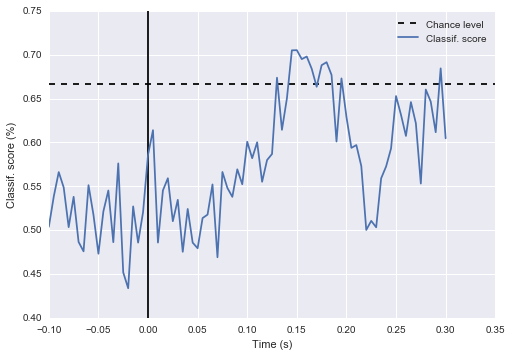

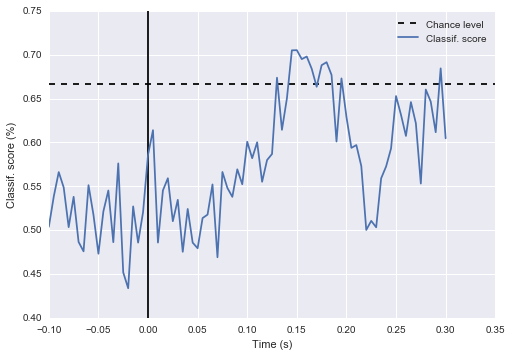

In [258]:
gat.plot(chance=True)

In [225]:
run_score

[0.098785425101214575,
 0.12523616734143048,
 0.10418353576248314,
 0.1408906882591093,
 0.0728744939271255,
 0.093657219973009437,
 0.10917678812415654,
 0.13049932523616731,
 0.11970310391363022,
 0.12483130904183534,
 0.13036437246963561,
 0.11470985155195682,
 0.14075573549257758,
 0.093657219973009437,
 0.16113360323886639,
 0.18232118758434548,
 0.15074224021592442,
 0.10391363022941968,
 0.17732793522267204,
 0.15681511470985154,
 0.20863697705802969,
 0.145748987854251,
 0.10917678812415654,
 0.10404858299595143,
 0.088394062078272592,
 0.13009446693657217,
 0.10931174089068825,
 0.13049932523616734,
 0.036167341430499322,
 0.1300944669365722,
 0.14561403508771931,
 0.11457489878542511,
 0.083265856950067468,
 0.12469635627530365,
 0.11470985155195679,
 0.13009446693657217,
 0.08866396761133602,
 0.11983805668016194,
 0.1194331983805668,
 0.12510121457489878,
 0.17732793522267204,
 0.12995951417004048,
 0.17206477732793521,
 0.1361673414304993,
 0.13022941970310389,
 0.16720647